In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import os
import pandas as pd

# Define the base image directory
base_dir = '/content/drive/MyDrive/arch/wheat_leaf (1)/'

# Folder to score mapping
folder_score_map = {
    'Healthy': 10,
    'stripe_rust': 4,
    'septoria': 6
}

# Collect image paths and scores
data = []
for folder, score in folder_score_map.items():
    folder_path = os.path.join(base_dir, folder)
    for fname in os.listdir(folder_path):
        if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
            relative_path = os.path.join(folder, fname)
            data.append({'image_path': relative_path, 'score': score})

# Create dataframe
df = pd.DataFrame(data)

# Sort by filename
df = df.sort_values(by='image_path')

# Save to CSV
csv_path = '/content/drive/MyDrive/arch/leaf_scores.csv'
df.to_csv(csv_path, index=False)

print(f" CSV created with {len(df)} entries at: {csv_path}")


 CSV created with 407 entries at: /content/drive/MyDrive/arch/leaf_scores.csv


In [3]:
import pandas as pd
import torch
from torch.utils.data import Dataset
from PIL import Image
import os
from torchvision import transforms

class LeafHealthScoreDataset(Dataset):
    def __init__(self, csv_file, image_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        img_path = os.path.join(self.image_dir, row['image_path'])
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        score = torch.tensor(row['score'], dtype=torch.float32)
        return image, score


In [4]:
from torchvision import transforms
from torch.utils.data import random_split, DataLoader

csv_path = '/content/drive/MyDrive/arch/leaf_scores.csv'
image_dir = '/content/drive/MyDrive/arch/wheat_leaf (1)'

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

full_dataset = LeafHealthScoreDataset(csv_path, image_dir, transform=transform)

# Split 80/20
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)


In [5]:
from torchvision import models
import torch.nn as nn

class ResNetRegressor(nn.Module):
    def __init__(self):
        super().__init__()
        self.base_model = models.resnet50(pretrained=True)
        self.base_model.fc = nn.Linear(self.base_model.fc.in_features, 1)

    def forward(self, x):
        return self.base_model(x).squeeze(1)


In [6]:
import torch.nn.functional as F
from torch import optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNetRegressor().to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.MSELoss()

# Training loop
for epoch in range(10):
    model.train()
    total_loss = 0
    for images, scores in train_loader:
        images, scores = images.to(device), scores.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, scores)   # MSELoss
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)

    # Validation
    model.eval()
    val_loss = 0
    val_mae = 0
    with torch.no_grad():
        for images, scores in val_loader:
            images, scores = images.to(device), scores.to(device)
            outputs = model(images)
            loss = criterion(outputs, scores)   # MSE
            val_loss += loss.item()

            mae = torch.mean(torch.abs(outputs - scores))   # MAE
            val_mae += mae.item()

    avg_val_loss = val_loss / len(val_loader)
    avg_val_mae = val_mae / len(val_loader)

    print(f"Epoch {epoch+1}, Train Loss: {avg_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val MAE: {avg_val_mae:.4f}")

torch.save(model.state_dict(), "/content/drive/MyDrive/arch/resnet50_wheat.pth")



/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 107MB/s]


Epoch 1, Train Loss: 25.7294, Val Loss: 33.5909, Val MAE: 5.4737
Epoch 2, Train Loss: 5.0072, Val Loss: 3.4530, Val MAE: 1.6065
Epoch 3, Train Loss: 1.3973, Val Loss: 1.1852, Val MAE: 0.8287
Epoch 4, Train Loss: 0.9491, Val Loss: 1.6604, Val MAE: 1.0174
Epoch 5, Train Loss: 0.5285, Val Loss: 0.7241, Val MAE: 0.5419
Epoch 6, Train Loss: 0.5544, Val Loss: 0.5082, Val MAE: 0.5681
Epoch 7, Train Loss: 0.4807, Val Loss: 0.4819, Val MAE: 0.5421
Epoch 8, Train Loss: 0.9620, Val Loss: 0.2518, Val MAE: 0.3678
Epoch 9, Train Loss: 0.5730, Val Loss: 0.3581, Val MAE: 0.4146
Epoch 10, Train Loss: 0.6868, Val Loss: 0.3324, Val MAE: 0.4491


predictions on unseen data

In [7]:
from torchvision import transforms
from PIL import Image

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])


In [8]:
import torch
import os

def predict_leaf_health(model, image_path, transform, device):
    model.eval()
    image = Image.open(image_path).convert('RGB')
    input_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_tensor)
        score = output.item()
    return round(score, 2)


In [9]:

unseen_folder = '/content/drive/MyDrive/arch/unseen_data'

predictions = []

for fname in os.listdir(unseen_folder):
    if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
        full_path = os.path.join(unseen_folder, fname)
        predicted_score = predict_leaf_health(model, full_path, transform, device)
        predictions.append((fname, predicted_score))

# Display results
for fname, score in predictions:
    print(f"{fname:30s} ➜ Predicted Score: {score}")


Brown_rust009.jpg              ➜ Predicted Score: 6.08
Brown_rust029.jpg              ➜ Predicted Score: 7.16
Brown_rust040.jpg              ➜ Predicted Score: 8.98
Brown_rust007.jpg              ➜ Predicted Score: 7.71
Brown_rust018.jpg              ➜ Predicted Score: 6.65
Brown_rust025.jpg              ➜ Predicted Score: 9.25
Brown_rust023.jpg              ➜ Predicted Score: 9.14
Brown_rust016.jpg              ➜ Predicted Score: 8.53
Brown_rust001.jpg              ➜ Predicted Score: 6.95
Brown_rust038.jpg              ➜ Predicted Score: 8.52
Brown_rust005.jpg              ➜ Predicted Score: 8.69
Brown_rust004.jpg              ➜ Predicted Score: 8.82
Brown_rust006.jpg              ➜ Predicted Score: 7.82
Brown_rust015.jpg              ➜ Predicted Score: 8.9
Brown_rust010.jpg              ➜ Predicted Score: 9.13
Brown_rust024.jpg              ➜ Predicted Score: 7.81
Brown_rust021.jpg              ➜ Predicted Score: 5.86
Brown_rust030.jpg              ➜ Predicted Score: 9.21
Brown_rust0

In [10]:
import pandas as pd

df_preds = pd.DataFrame(predictions, columns=['image_name', 'predicted_score'])
df_preds.to_csv('/content/drive/MyDrive/arch/predicted_scores.csv', index=False)
print("Saved predictions to predicted_scores.csv")


Saved predictions to predicted_scores.csv


second approach classifier

In [11]:
!pip install torch torchvision


In [12]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
import os

data_path = '/content/drive/MyDrive/arch/wheat_leaf (1)'

# List subfolders
print("Subfolders inside dataset directory:")
if os.path.exists(data_path):
    for sub in os.listdir(data_path):
        sub_path = os.path.join(data_path, sub)
        if os.path.isdir(sub_path):
            imgs = [f for f in os.listdir(sub_path) if f.lower().endswith(('.jpg','.jpeg','.png'))]
            print(f" - {sub}: {len(imgs)} images")
else:
    print(" Path does not exist:", data_path)


Subfolders inside dataset directory:
 - Healthy: 102 images
 - septoria: 97 images
 - stripe_rust: 208 images


In [14]:
from pathlib import Path
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
import torch, shutil

data_path = Path('/content/drive/MyDrive/arch/wheat_leaf (1)')

# 1. Detect empty class folders
valid_exts = {'.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff', '.webp'}
empty_dirs = []
for d in data_path.iterdir():
    if d.is_dir():
        n_imgs = sum(1 for p in d.rglob('*') if p.suffix.lower() in valid_exts)
        if n_imgs == 0:
            empty_dirs.append(d)

# 2. Move empty folders aside so ImageFolder won’t see them
if empty_dirs:
    ignore_root = data_path.with_name(data_path.name + '_IGNORED_EMPTY')
    ignore_root.mkdir(exist_ok=True)
    for d in empty_dirs:
        shutil.move(str(d), str(ignore_root / d.name))
    print(f"Moved empty class folders out of the dataset: {[d.name for d in empty_dirs]}")
else:
    print("No empty class folders found.")

# 3. Now load dataset safely
transform = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor()])
full_dataset = datasets.ImageFolder(root=str(data_path), transform=transform)
print("Classes:", full_dataset.classes, "Total images:", len(full_dataset))

# 4. Stratified split (fallback to random if needed)
indices = list(range(len(full_dataset)))
targets = full_dataset.targets
try:
    train_idx, val_idx = train_test_split(indices, test_size=0.2, random_state=42, stratify=targets)
except ValueError:
    train_idx, val_idx = train_test_split(indices, test_size=0.2, random_state=42, shuffle=True)

train_ds = Subset(full_dataset, train_idx)
val_ds   = Subset(full_dataset, val_idx)
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True,  num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=32, shuffle=False, num_workers=2, pin_memory=True)
print(f"Train/Val sizes: {len(train_ds)} / {len(val_ds)}")


No empty class folders found.
Classes: ['Healthy', 'septoria', 'stripe_rust'] Total images: 407
Train/Val sizes: 325 / 82


In [15]:
import torch.nn as nn
import torchvision.models as models


model = models.resnet50(pretrained=True)

# Replaces last layer for 3 classes
model.fc = nn.Linear(model.fc.in_features, 3)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [16]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training loop
epochs = 5
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss:.4f}")


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 1/5, Loss: 6.2187
Epoch 2/5, Loss: 1.1753
Epoch 3/5, Loss: 0.8077
Epoch 4/5, Loss: 1.8961
Epoch 5/5, Loss: 1.2020


In [17]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Validation Accuracy: {100 * correct / total:.2f}%")


Validation Accuracy: 92.68%


In [18]:
import pandas as pd
from torchvision.datasets import ImageFolder
from tqdm import tqdm
import os

# Put model in evaluation mode
model.eval()

# Load the full dataset again (with image paths)
full_dataset = ImageFolder(root=data_path, transform=transform)
full_loader = DataLoader(full_dataset, batch_size=32, shuffle=False)

# Reverse class mapping ( 0: 'Healthy', 1: 'septoria', 2: 'stripe_rust')
class_to_label = {v: k for k, v in full_dataset.class_to_idx.items()}

# Prepare rows for CSV
csv_rows = []
image_idx = 0

with torch.no_grad():
    for inputs, _ in tqdm(full_loader):
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        for i in range(inputs.size(0)):
            img_path = full_dataset.samples[image_idx][0]
            folder, fname = img_path.split('/')[-2], img_path.split('/')[-1]
            pred_class = predicted[i].item()

            # Disease score mapping
            disease_score = {0: 10, 1: 3, 2: 2}[pred_class]

            # Estimated scores
            if pred_class == 0:  # Healthy
                appearance = 9.5
                growth = 9.0
                weed = 10.0
            elif pred_class == 1:  # Septoria
                appearance = 5.0
                growth = 6.0
                weed = 9.5
            else:  # Stripe Rust
                appearance = 4.5
                growth = 5.0
                weed = 8.0

            csv_rows.append({
                'filename': f"{folder}/{fname}",
                'class': pred_class,
                'disease': disease_score,
                'appearance': appearance,
                'growth': growth,
                'weed': weed
            })

            image_idx += 1

# Save the new CSV
output_csv = '/content/drive/MyDrive/arch/leaf_scores_auto.csv'
df = pd.DataFrame(csv_rows)
df.to_csv(output_csv, index=False)

print(f" Auto-labeled CSV created at: {output_csv}")


100%|██████████| 13/13 [02:59<00:00, 13.78s/it]


 Auto-labeled CSV created at: /content/drive/MyDrive/arch/leaf_scores_auto.csv


Multi-Indicator Health Score Regression Model
We’ll build a model that takes a leaf image and predicts:

disease score

appearance score

growth score

weed score
All in the 1–10 range.

In [19]:
from torch.utils.data import Dataset
from PIL import Image

class LeafHealthScoreDataset(Dataset):
    def __init__(self, csv_path, image_dir, transform=None):
        self.data = pd.read_csv(csv_path)
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        image_path = os.path.join(self.image_dir, row['filename'])
        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        scores = torch.tensor([
            row['disease'], row['appearance'],
            row['growth'], row['weed']
        ], dtype=torch.float32)
        return image, scores


In [20]:
# Paths
csv_path = '/content/drive/MyDrive/arch/leaf_scores_auto.csv'
image_dir = '/content/drive/MyDrive/arch/wheat_leaf'



full_dataset = LeafHealthScoreDataset(csv_path, image_dir, transform)

train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)


In [21]:
import pandas as pd
import os
from PIL import Image, UnidentifiedImageError
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# Updated dataset class that skips missing or unreadable images
class LeafHealthScoreDataset(Dataset):
    def __init__(self, csv_path, image_dir, transform=None):
        self.data = pd.read_csv(csv_path)
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        image_path = os.path.join(self.image_dir, row['filename'])

        try:
            image = Image.open(image_path).convert('RGB')
            if self.transform:
                image = self.transform(image)
            scores = torch.tensor([
                row['disease'], row['appearance'],
                row['growth'], row['weed']
            ], dtype=torch.float32)
            return image, scores

        except (FileNotFoundError, UnidentifiedImageError):
            return self.__getitem__((idx + 1) % len(self))

# Paths
csv_path = '/content/drive/MyDrive/arch/leaf_scores_auto.csv'
image_dir = '/content/drive/MyDrive/arch/wheat_leaf (1)'

# Image transform
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])


In [22]:
from sklearn.model_selection import train_test_split
import torch

full_dataset = LeafHealthScoreDataset(csv_path, image_dir, transform)

# Split 80/20
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size

train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)


In [23]:
import torch.nn as nn
import torchvision.models as models

class MultiIndicatorRegressor(nn.Module):
    def __init__(self):
        super().__init__()
        base = models.resnet18(pretrained=True)
        self.backbone = nn.Sequential(*list(base.children())[:-1])
        self.head = nn.Sequential(
            nn.Flatten(),
            nn.Linear(base.fc.in_features, 256),
            nn.ReLU(),
            nn.Linear(256, 4)  # Predict 4 health scores
        )

    def forward(self, x):
        x = self.backbone(x)
        x = self.head(x)
        return torch.sigmoid(x) * 9 + 1  # Scale to 1–10 range

# Set up model and device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MultiIndicatorRegressor().to(device)


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 73.6MB/s]


In [24]:
import torch.optim as optim

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training loop
epochs = 5
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss:.4f}")


KeyboardInterrupt: 

In [ ]:
model.eval()
val_loss = 0.0
with torch.no_grad():
    for inputs, targets in val_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        val_loss += loss.item()

print(f"Validation MSE: {val_loss:.4f}")


GRADCAM to model

In [ ]:
# Store activations and gradients
feature_maps = None
gradients = None

def save_activation_hook(module, input, output):
    global feature_maps
    feature_maps = output.detach()

def save_gradient_hook(module, grad_input, grad_output):
    global gradients
    gradients = grad_output[0].detach()


In [ ]:
# Hook into the last conv layer of ResNet18 (layer4)
last_conv_layer = model.backbone[-1]  # layer4 in resnet18
last_conv_layer.register_forward_hook(save_activation_hook)
last_conv_layer.register_backward_hook(save_gradient_hook)


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image

def generate_gradcam(input_tensor, target_index):
    model.eval()
    input_tensor = input_tensor.unsqueeze(0).to(device)

    # Forward pass
    output = model(input_tensor)
    score = output[0, target_index]

    # Backward pass
    model.zero_grad()
    score.backward()

    # Compute GradCAM
    weights = torch.mean(gradients, dim=(2, 3), keepdim=True)  # Global average pooling
    cam = torch.sum(weights * feature_maps, dim=1).squeeze()
    cam = torch.relu(cam)

    # Normalize
    cam -= cam.min()
    cam /= cam.max()

    # Resize to input size
    cam = cam.cpu().numpy()
    cam = cv2.resize(cam, (224, 224))

    # Convert to heatmap
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    return heatmap


In [ ]:
# Load a sample image from your dataset
img, scores = full_dataset[0]  # Change index to test others
input_tensor = img.unsqueeze(0).to(device)

# Indicator names
indicators = ['disease', 'appearance', 'growth', 'weed']

# Generate and plot GradCAMs
for i in range(4):  # for each score
    heatmap = generate_gradcam(img, target_index=i)

    # Original image as numpy
    img_np = np.transpose(img.cpu().numpy(), (1, 2, 0))
    img_np = img_np / img_np.max()

    # Overlay heatmap
    overlay = 0.4 * heatmap + 0.6 * img_np
    overlay = np.clip(overlay, 0, 1)

    # Show it
    plt.figure(figsize=(5, 5))
    plt.title(f"GradCAM for: {indicators[i]} score")
    plt.imshow(overlay)
    plt.axis('off')
    plt.show()


In [ ]:
model.eval()
all_labels = []
all_preds = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)  # get class index

        all_labels.extend(labels.cpu().numpy().tolist())
        all_preds.extend(preds.cpu().numpy().tolist())

print("Labels length:", len(all_labels))
print("Preds length:", len(all_preds))


In [ ]:
from torch.utils.data import random_split

# Dataset sizes
train_size = int(0.7 * len(full_dataset))
val_size   = int(0.15 * len(full_dataset))
test_size  = len(full_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32)
test_loader  = DataLoader(test_dataset, batch_size=32)


In [ ]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Step 1: Put model in evaluation mode
model.eval()

y_true = []
y_pred = []

# Step 2: Loop through test loader
with torch.no_grad():
    for images, labels in test_loader:   # make sure test_loader is defined
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Step 3: Define class names
class_names = ["Healthy", "Septoria", "Stripe Rust"]

# Step 4: Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Step 5: Plot
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for Wheat Leaf Classification")
plt.show()

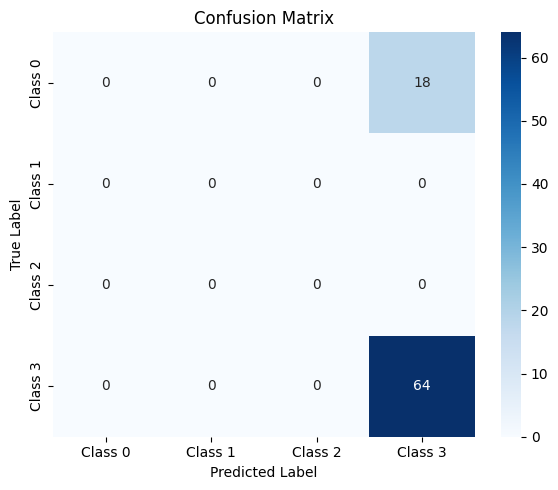

In [25]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


# Set which loader to evaluate on
EVAL_LOADER = test_loader if 'test_loader' in globals() else val_loader

# Optional: override class names if needed
CLASS_NAMES = getattr(getattr(EVAL_LOADER, 'dataset', None), 'dataset', getattr(EVAL_LOADER, 'dataset', None))
CLASS_NAMES = getattr(CLASS_NAMES, 'classes', None) or ["Healthy", "Septoria", "Stripe Rust"]


def to_numpy(x):
    if isinstance(x, torch.Tensor):
        return x.detach().cpu().numpy()
    return np.asarray(x)

def coerce_to_class_indices(arr):
    """
    Convert predictions/labels into 1-D integer class indices.
    Handles:
      - shape (N,) ints/floats -> rounds floats in {0,1} to binary
      - shape (N,K) one-hot or probabilities -> argmax along axis=1
    Raises if looks like regression (continuous values not in {0,1}).
    """
    a = to_numpy(arr)

    # Squeeze extra dimensions like (N,1) -> (N,)
    while a.ndim > 2:
        a = np.squeeze(a, axis=-1)

    if a.ndim == 1:
        if np.issubdtype(a.dtype, np.floating):
            # If all values are in [0,1], treat as binary probs -> threshold at 0.5
            if np.all((a >= 0.0) & (a <= 1.0)):
                return (a >= 0.5).astype(int)
            # If floats but not probs, likely regression scores -> error
            raise ValueError(
                "Detected continuous 1-D targets/preds (regression-like). "
                "For a confusion matrix, provide class indices or use binning."
            )
        return a.astype(int)

    if a.ndim == 2:
        # One-hot (rows sum≈1) or probabilities -> argmax
        return np.argmax(a, axis=1).astype(int)

    raise ValueError(f"Unsupported array shape for classification targets/preds: {a.shape}")

# Device
try:
    device = next(model.parameters()).device
except Exception:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

# Evaluation
model.eval()
y_true_list, y_pred_list = [], []

with torch.no_grad():
    for images, labels in EVAL_LOADER:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)

        # Expect classifier logits of shape [B, K]
        if outputs.ndim == 2 and outputs.shape[1] > 1:
            preds = outputs.argmax(dim=1)
        elif outputs.ndim == 2 and outputs.shape[1] == 1:

            raise ValueError(
                f"Model output shape {tuple(outputs.shape)} suggests a single-output head. "
                "If binary classification, supply 2-class logits; if regression, bin predictions first."
            )
        else:
            raise ValueError(
                f"Unexpected model output shape {tuple(outputs.shape)}. Expected [B, K] for K classes."
            )

        y_true_list.append(labels.detach().cpu())
        y_pred_list.append(preds.detach().cpu())

# COERCE TO 1-D INT LABELS
y_true = torch.cat(y_true_list, dim=0)
y_pred = torch.cat(y_pred_list, dim=0)

y_true = coerce_to_class_indices(y_true)
y_pred = coerce_to_class_indices(y_pred)

# Safety: enforce same label set and length match
assert y_true.shape == y_pred.shape, f"y_true and y_pred must have same shape; got {y_true.shape} vs {y_pred.shape}"

num_classes = int(max(y_true.max(), y_pred.max())) + 1 if y_true.size > 0 else len(CLASS_NAMES)
if len(CLASS_NAMES) != num_classes:
    CLASS_NAMES = [f"Class {i}" for i in range(num_classes)]

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred, labels=np.arange(num_classes))

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


In [29]:

# FULL-SIZE GRAD-CAM FOR WHEAT LEAVES


!pip install -q grad-cam opencv-python pillow

import os
import cv2
import numpy as np
from pathlib import Path
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget


DATA_ROOT = "/content/drive/MyDrive/arch/wheat_leaf (1)"
MODEL_PATH = "/content/drive/MyDrive/arch/resnet50_wheat.pth"
OUT_DIR = "/content/drive/MyDrive/arch/gradcam_full"
VAL_SPLIT = 0.2
BATCH_SIZE = 16
MAX_SAMPLES = 20   # how many Grad-CAM images to generate
ALPHA = 0.35

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
Path(OUT_DIR).mkdir(parents=True, exist_ok=True)

# Transforms
val_tf = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

# Dataset & Loader
full_ds = datasets.ImageFolder(root=DATA_ROOT, transform=val_tf)
val_size = int(len(full_ds) * VAL_SPLIT)
train_size = len(full_ds) - val_size
_, val_ds = random_split(full_ds, [train_size, val_size])
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)

class_names = full_ds.classes
num_classes = len(class_names)


# Load Model
model = models.resnet50(weights=None)
model.fc = nn.Linear(model.fc.in_features, num_classes)
state_dict = torch.load(MODEL_PATH, map_location=device)
model.load_state_dict(state_dict, strict=False)
model = model.to(device).eval()

# Target Layer for Grad-CAM
target_layer = model.layer4[-1]

# Helper: denormalize image
def denormalize(img_tensor):
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = img_tensor.detach().cpu().permute(1, 2, 0).numpy()
    img = (img * std + mean).clip(0, 1)
    return (img * 255).astype(np.uint8)

# Helper: mask leaf (suppress soil/bg)
def leaf_mask_hsv(rgb):
    hsv = cv2.cvtColor(rgb, cv2.COLOR_RGB2HSV)
    H, S, V = hsv[:,:,0], hsv[:,:,1], hsv[:,:,2]
    mask = (S > 40) & (V > 40)
    mask = mask.astype(np.uint8) * 255
    mask = cv2.medianBlur(mask, 5)
    return mask > 0

# Run Grad-CAM
def run_gradcam(model, loader, class_names, out_dir, max_samples=20):
    cam = GradCAM(model=model, target_layers=[target_layer])
    saved = 0

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        preds = model(images).argmax(1)

        for i in range(images.size(0)):
            if saved >= max_samples: break

            input_img = images[i:i+1]
            target = [ClassifierOutputTarget(int(preds[i]))]
            grayscale_cam = cam(input_tensor=input_img, targets=target)[0]

            # original image
            orig = denormalize(images[i])
            h, w = orig.shape[:2]

            # resize CAM to full image size
            cam_resized = cv2.resize(grayscale_cam, (w, h))
            cam_resized = (cam_resized - cam_resized.min()) / (cam_resized.max() - cam_resized.min() + 1e-8)

            # suppress background
            mask = leaf_mask_hsv(orig)
            cam_resized = cam_resized * mask.astype(np.float32)
            if cam_resized.max() > 1e-6:
                cam_resized /= cam_resized.max()

            # overlay
            heatmap = cv2.applyColorMap(np.uint8(255 * cam_resized), cv2.COLORMAP_JET)
            heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
            overlay = cv2.addWeighted(orig, 0.75, heatmap, ALPHA, 0)

            # save
            pred_cls = class_names[int(preds[i])]
            true_cls = class_names[int(labels[i])]
            fn = Path(out_dir) / f"{saved:03d}_pred-{pred_cls}_true-{true_cls}.jpg"
            Image.fromarray(overlay).save(fn)
            saved += 1

        if saved >= max_samples: break

    print(f" Saved {saved} Grad-CAM images to {out_dir}")

#  Execute
run_gradcam(model, val_loader, class_names, OUT_DIR, max_samples=MAX_SAMPLES)


 Saved 20 Grad-CAM images to /content/drive/MyDrive/arch/gradcam_full


In [32]:

# GRAD-CAM WITH LEAF-ONLY HIGHLIGHTS (FULL IMAGE)


!pip install -q grad-cam opencv-python pillow

import os, cv2, numpy as np
from pathlib import Path
from PIL import Image
import torch, torch.nn as nn
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget


DATA_ROOT = "/content/drive/MyDrive/arch/wheat_leaf (1)"
MODEL_PATH = "/content/drive/MyDrive/arch/resnet50_wheat.pth"
OUT_DIR = "/content/drive/MyDrive/arch/gradcam_leaf_only"
VAL_SPLIT = 0.2
BATCH_SIZE = 16
MAX_SAMPLES = 20
ALPHA = 0.35   # overlay transparency

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
Path(OUT_DIR).mkdir(parents=True, exist_ok=True)

#  TRANSFORMS
val_tf = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

# DATASET & LOADER
full_ds = datasets.ImageFolder(root=DATA_ROOT, transform=val_tf)
val_size = int(len(full_ds) * VAL_SPLIT)
train_size = len(full_ds) - val_size
_, val_ds = random_split(full_ds, [train_size, val_size])
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)

class_names = full_ds.classes
num_classes = len(class_names)




# Build model with correct number of classes
model = models.resnet50(weights=None)
model.fc = nn.Linear(model.fc.in_features, len(full_ds.classes))

# Load backbone weights, ignore fc mismatch
state_dict = torch.load(MODEL_PATH, map_location=device)
new_state_dict = {k.replace("base_model.", ""): v for k,v in state_dict.items() if "fc" not in k}
model.load_state_dict(new_state_dict, strict=False)

model = model.to(device).eval()


#  GRAD-CAM TARGET LAYER
target_layer = model.layer4[-1]

#  HELPERS
def denormalize(img_tensor):
    """Convert normalized tensor back to uint8 RGB image."""
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = img_tensor.detach().cpu().permute(1,2,0).numpy()
    img = (img * std + mean).clip(0,1)
    return (img * 255).astype(np.uint8)

def leaf_mask_hsv(rgb):
    """Strict HSV-based mask for leaf pixels only."""
    hsv = cv2.cvtColor(rgb, cv2.COLOR_RGB2HSV)
    H, S, V = hsv[:,:,0], hsv[:,:,1], hsv[:,:,2]
    mask = (S > 40) & (V > 40)    # remove dull background
    mask = mask.astype(np.uint8) * 255
    mask = cv2.medianBlur(mask, 5)
    return mask > 0

#  GRAD-CAM RUNNER
def run_gradcam_leaf_only(model, loader, class_names, out_dir, max_samples=20):
    cam = GradCAM(model=model, target_layers=[target_layer])
    saved = 0

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        preds = model(images).argmax(1)

        for i in range(images.size(0)):
            if saved >= max_samples: break

            input_img = images[i:i+1]
            target = [ClassifierOutputTarget(int(preds[i]))]
            grayscale_cam = cam(input_tensor=input_img, targets=target)[0]

            # recover original RGB
            orig = denormalize(images[i])
            h, w = orig.shape[:2]

            # resize CAM to full image size
            cam_resized = cv2.resize(grayscale_cam, (w, h))
            cam_resized = (cam_resized - cam_resized.min()) / (cam_resized.max() - cam_resized.min() + 1e-8)

            # force CAM only on leaf pixels
            mask = leaf_mask_hsv(orig)
            cam_resized = cam_resized * mask.astype(np.float32)
            if cam_resized.max() > 1e-6:
                cam_resized /= cam_resized.max()

            # overlay CAM
            heatmap = cv2.applyColorMap(np.uint8(255 * cam_resized), cv2.COLORMAP_JET)
            heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
            overlay = cv2.addWeighted(orig, 0.75, heatmap, ALPHA, 0)

            # save result
            pred_cls = class_names[int(preds[i])]
            true_cls = class_names[int(labels[i])]
            fn = Path(out_dir) / f"{saved:03d}_pred-{pred_cls}_true-{true_cls}.jpg"
            Image.fromarray(overlay).save(fn)
            saved += 1

        if saved >= max_samples: break

    print(f" Saved {saved} leaf-only Grad-CAM images to {out_dir}")

#  EXECUTE
run_gradcam_leaf_only(model, val_loader, class_names, OUT_DIR, max_samples=MAX_SAMPLES)


 Saved 20 leaf-only Grad-CAM images to /content/drive/MyDrive/arch/gradcam_leaf_only
